# Nonlinear Auto-regressive Network with Exogenous Inputs
带外源输入的非线性自动回归网络神经网络（NARX）是一种循环动态神经网络。它们已被用于非线性动态系统的建模，如热交换器、废水处理厂和石油精炼厂催化重整系统、生物系统的运动，甚至用于预测太阳辐射。

在本章中，我们说明了构建一个NARX模型来预测联合王国的年度失业率。我们的目标是建立一个模型，将实际水平预测在模型预测的2个标准差的舒适区间内。

In [1]:
import numpy as np
import pandas as pd
loc = "UK-Economic.xls"
Excel_file = pd.ExcelFile(loc)
spreadsheet = Excel_file.parse('A1. Headline series')

分析所用的第一年是1855年，最后一年是2015年。

In [2]:
spreadsheet.iloc[201 ,0]

1855

In [3]:
spreadsheet.iloc[361 ,0]

2015

## Working with Macroeconomic Variables

In [4]:
unemployment = spreadsheet.iloc[201:362 ,15]

属性集由四个宏观经济变量组成。
- 1. 消费者物价通胀率
- 2. 中央银行等级
- 3. 国债占名义国内生产总值的百分比
- 4. 经济增长（GDP）与趋势的偏差
我们有兴趣预测明年的失业率，给定今年每个属性的值。我们可以通过选择我们的属性数据，将每年的失业率与去年的属性值进行匹配。换句话说，通过将属性按时间步长（在本例中为年份）滞后。


In [5]:
inflation = spreadsheet.iloc[200:361 ,28]
bank_rate = spreadsheet.iloc[200:361 ,30]
debt = spreadsheet.iloc[200:361 ,57]
GDP_trend = spreadsheet.iloc[200:361 ,3]

In [6]:
x = pd.concat([ GDP_trend, debt, bank_rate,inflation ], axis=1)

In [7]:
x.columns = ["GDP_trend","debt","bank_rate","inflation"]

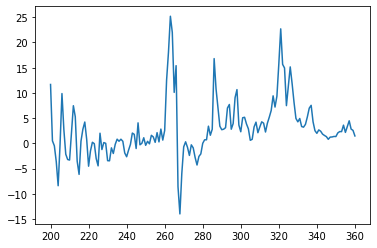

In [8]:
import matplotlib.pyplot as plt 
plt.plot(inflation)

x中的每个属性都是数据类型为Object。Object 是 pandas 的数据类型，对应于原生的 Python 字符串。换句话说，这些属性中的信息被存储为文本字符串。它们需要转换为数值才能在神经网络中使用。

In [9]:
x['debt'] = x['debt']. astype('float64')
x['GDP_trend'] = x['GDP_trend']. astype('float64')
x['bank_rate'] = x['bank_rate']. astype('float64')
x['inflation'] = x['inflation']. astype('float64')

In [10]:
y = unemployment
y = pd.to_numeric(y)
loc = "economic_x.csv"
x.to_csv(loc)
loc = "economic_y.csv"
y.to_csv(loc)

## Scaling Data

In [14]:
x = pd.read_csv("economic_x.csv")
x = x.drop( x.columns[[0]], axis=1)
y = pd.read_csv("economic_y.csv", header=None)
y = y.drop ( y.columns[[0]], axis =1)

In [15]:
from sklearn import preprocessing
scaler_x = preprocessing.MinMaxScaler(feature_range=(0,1))
x = np.array(x).reshape((len(x), 4))
x = scaler_x.fit_transform(x)
scaler_y = preprocessing.MinMaxScaler(feature_range=(0,1))
y = np.array(y).reshape((len(y), 1))
y = scaler_y.fit_transform(y)
y = y.tolist()
x = x.tolist()

## A Tool for Rapid NARX Model Construction

In [16]:
from pyneurgen.neuralnet import NeuralNet
from pyneurgen.recurrent import NARXRecurrent

In [17]:
import random
random.seed(2020)
input_nodes = 4
hidden_nodes = 10
output_nodes = 1
output_order = 1
input_order = 3
incoming_weight_from_output = 0.1
incoming_weight_from_input = 0.8
fit1 = NeuralNet ()
fit1.init_layers( input_nodes, [hidden_nodes], output_nodes, 
                  NARXRecurrent(output_order,
                  incoming_weight_from_output,
                  input_order,
                  incoming_weight_from_input))
fit1.randomize_network()
fit1.layers[1].set_activation_type ('sigmoid')
fit1.set_learnrate(0.35)
fit1.set_all_inputs(x)
fit1.set_all_targets(y)

In [18]:
length = len(x)
learn_end_point = int(length * 0.85)
fit1.set_learn_range(0, learn_end_point)
fit1.set_test_range(learn_end_point+1, length-1)

In [19]:
fit1.learn( epochs=12, show_epoch_results=True, random_testing=False )

epoch: 0 MSE: 0.014821740545483667
epoch: 1 MSE: 0.007822204789948828
epoch: 2 MSE: 0.0063438946234021755
epoch: 3 MSE: 0.005604312175941225
epoch: 4 MSE: 0.005258048965205997
epoch: 5 MSE: 0.005131890627269868
epoch: 6 MSE: 0.005128760925907184
epoch: 7 MSE: 0.005190773052589076
epoch: 8 MSE: 0.005282627131607359
epoch: 9 MSE: 0.005382984585835005
epoch: 10 MSE: 0.005479380118561124
epoch: 11 MSE: 0.005564959100973381


In [20]:
mse = fit1.test()
round(mse, 6)

0.039585

In [28]:
forecast = [np.exp(
        scaler_y.inverse_transform(
            np.array(item).reshape(-1, 1)
        ))[1][0] for item in fit1.test_targets_activations]
print("forecasts are(时间长度为%d):" % len(forecast))
print(forecast)

forecasts are(时间长度为23):
[718.9164439797106, 149.98367908629425, 33.519667051833785, 32.86007448561515, 35.28924048228441, 32.73448416508359, 44.659072573207084, 31.870387226201334, 33.69642056231641, 34.48641804502385, 17.614580745596083, 18.12865435623405, 12.855996849432483, 19.763487404573546, 22.79865378214354, 36.32233034724055, 46.77971330682525, 18.035674903547818, 5.205092157313288, 2.583857349180108, 2.5669006113846065, 2.6918676394453724, 2.7752686318272874]


In [32]:
pred = [item[1][0] for item in fit1.test_targets_activations]
pred2 = scaler_y.inverse_transform(np.array(pred).reshape((len(pred), 1)))
pred2 = np.exp(pred2)

In [33]:
pred2

array([[718.91644398],
       [149.98367909],
       [ 33.51966705],
       [ 32.86007449],
       [ 35.28924048],
       [ 32.73448417],
       [ 44.65907257],
       [ 31.87038723],
       [ 33.69642056],
       [ 34.48641805],
       [ 17.61458075],
       [ 18.12865436],
       [ 12.85599685],
       [ 19.7634874 ],
       [ 22.79865378],
       [ 36.32233035],
       [ 46.77971331],
       [ 18.0356749 ],
       [  5.20509216],
       [  2.58385735],
       [  2.56690061],
       [  2.69186764],
       [  2.77526863]])